In [2]:
%%time
import sagemaker
from sagemaker import get_execution_role

role = get_execution_role()
print(role)

sess = sagemaker.Session()
bucket='your-bucket-name' 
prefix = 'cv/facemask'

Wall time: 0 ns


In [3]:
from sagemaker.amazon.amazon_estimator import get_image_uri

training_image = get_image_uri(sess.boto_region_name, 'image-classification', repo_version="latest")
print (training_image)

### Image Pre processing

#### Find the im2rec.py script on this system

In [4]:
dataset_name = 'images'

In [4]:
# Find im2rec in our environment and set up some other vars in our environemnt

base_dir='/tmp'

%env BASE_DIR=$base_dir
%env S3_DATA_BUCKET_NAME = $bucket
%env DATASET_NAME = $dataset_name

import sys,os

suffix='im2rec.py'
im2rec = list(filter( (lambda x: os.path.isfile(x + suffix )), sys.path))[0] + suffix
%env IM2REC=$im2rec

#### Get images from S3

In [37]:
rm tmp/images/with_mask/*

In [36]:
rm tmp/images/without_mask/*

In [38]:
# Pull our images from S3, its working
!aws s3 sync s3://$S3_DATA_BUCKET_NAME/$DATASET_NAME/ ./$DATASET_NAME --quiet

### Create RecordIO files from our training images
The `im2rec.py` script can create LST files and/or RecordIO files from our training data. 

More info here: https://mxnet.incubator.apache.org/versions/master/faq/recordio.html

In [6]:
#%%bash
#cd tmp
#ls

In [41]:
%%bash
rm *.rec
rm *.lst

rm: cannot remove ‘*.rec’: No such file or directory


In [7]:
#pwd

In [42]:
%%bash
python $IM2REC --list --recursive --pass-through --test-ratio=0.3 --train-ratio=0.7 $DATASET_NAME $DATASET_NAME > ${DATASET_NAME}_classes

In [43]:
%%bash
echo "Label classes:"
cat ${DATASET_NAME}_classes

Label classes:
with_mask 0
without_mask 1


### Creating recordIO format

In [8]:
%%bash
python $IM2REC --num-thread=4 ${DATASET_NAME}_train.lst $DATASET_NAME

In [9]:
%%bash
python $IM2REC --num-thread=4 ${DATASET_NAME}_test.lst $DATASET_NAME

In [46]:
ls -lh *.rec

-rw-rw-r-- 1 ec2-user ec2-user 49M Sep 23 10:22 images_test.rec
-rw-rw-r-- 1 ec2-user ec2-user 97M Sep 23 10:21 images_train.rec


In [114]:
%%bash
# Use the IM2REC script to convert our images into RecordIO files

# Clean up our working dir of existing LST and REC files
#cd $BASE_DIR
#rm *.rec
#rm *.lst

# First we need to create two LST files (training and test lists), noting the correct label class for each image
# We'll also save the output of the LST files command, since it includes a list of all of our label classes
#echo "Creating LST files"
#python $IM2REC --list --recursive --pass-through --test-ratio=0.3 --train-ratio=0.7 $DATASET_NAME $DATASET_NAME > ${DATASET_NAME}_classes

#echo "Label classes:"
#cat ${DATASET_NAME}_classes

# Then we create RecordIO files from the LST files
#echo "Creating RecordIO files"
#python $IM2REC --num-thread=4 ${DATASET_NAME}_train.lst $DATASET_NAME
#python $IM2REC --num-thread=4 ${DATASET_NAME}_test.lst $DATASET_NAME
#ls -lh *.rec

### Upload our training and test data RecordIO files so we can train with them
Now that we have our training and test .rec files, we upload them to S3 so SageMaker can use them for training

In [10]:
# Upload our train and test RecordIO files to S3 in the bucket that our sagemaker session is using
#bucket = sess.default_bucket()
bucket='your-bucket' 
prefix = 'cv/facemask'

s3train_path = 's3://{}/{}/train/'.format(bucket, prefix)
s3validation_path = 's3://{}/{}/validation/'.format(bucket, prefix)

# Clean up any existing data
#!aws s3 rm s3://{bucket}/{dataset_name}/train --recursive
#!aws s3 rm s3://{bucket}/{dataset_name}/validation --recursive

# Upload the rec files to the train and validation channels
!aws s3 cp images_train.rec $s3train_path
!aws s3 cp images_test.rec $s3validation_path

### Configure the data for our model training to use
Finally, we tell SageMaker where to find these RecordIO files to use for training

In [48]:
train_data = sagemaker.session.s3_input(
    s3train_path, 
    distribution='FullyReplicated', 
    content_type='application/x-recordio', 
    s3_data_type='S3Prefix'
)

validation_data = sagemaker.session.s3_input(
    s3validation_path, 
    distribution='FullyReplicated', 
    content_type='application/x-recordio', 
    s3_data_type='S3Prefix'
)

data_channels = {'train': train_data, 'validation': validation_data}

's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


### Training

In [49]:
num_classes=! ls -l {dataset_name} | wc -l
num_classes=int(num_classes[0]) - 1

num_training_samples=! cat images_train.lst | wc -l
num_training_samples = int(num_training_samples[0])

In [97]:
num_training_samples

2678

In [50]:
s3_output_location = 's3://{}/{}/output'.format(bucket, prefix)
face_mask_detection = sagemaker.estimator.Estimator(training_image,
                                         role, 
                                         train_instance_count=1, 
                                         train_instance_type='ml.p2.xlarge',
                                         train_volume_size = 50,
                                         train_max_run = 360000,
                                         input_mode= 'Pipe',
                                         output_path=s3_output_location,
                                         sagemaker_session=sess)

Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.


In [98]:
face_mask_detection.set_hyperparameters(num_layers=18,
                             use_pretrained_model=1,
                             image_shape = "3,224,224",
                             num_classes=num_classes,
                             mini_batch_size=128,
                             epochs=2,
                             learning_rate=0.01,
                             top_k=2,
                             num_training_samples=num_training_samples,
                             resize = 256,
                             precision_dtype='float32')

In [11]:
#start training
face_mask_detection.fit(inputs=data_channels, logs=True)

### Deploy

In [100]:
facemask_predictor = face_mask_detection.deploy(initial_instance_count = 1,
                                          instance_type = 'ml.m4.xlarge')

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


---------------!

In [ ]:
##Clean up endpoint
#facemask_predictor.delete_endpoint()

In [101]:
import json
import numpy as np

def get_face_mask_detection(file_name=file_name):
    
    with open(file_name, 'rb') as f:
        payload = f.read()
        payload = bytearray(payload)

    facemask_predictor.content_type = 'application/x-image'
    result = json.loads(facemask_predictor.predict(payload))
    # the result will output the probabilities for all classes
    # find the class with maximum probability and print the class index
    index = np.argmax(result)
    object_categories = ['mask', 'nomask']
    #print("Result: label - " + object_categories[index] + ", probability - " + str(result[index]))
    #result = "Result: label - " + object_categories[index] + ", probability - " + str(result[index])
    return "Result: label - " + object_categories[index] + ", probability - " + str(result[index])

In [110]:
#import s3fs
#from PIL import Image
#fs = s3fs.S3FileSystem()
#with fs.open(f's3://bucket/cv/facemask/test01.jpg') as f:
#    display(Image.open(f))
#file_name = open('https://aws-sagemaker-aiml-usecases.s3.us-east-2.amazonaws.com/cv/facemask/test01.jpg', 'rb').read()

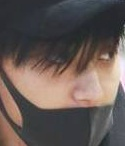

In [152]:
# test image
from IPython.display import Image
file_name = 'test01.jpg'
Image(file_name)  

In [153]:
get_face_mask_detection(file_name)

'Result: label - mask, probability - 0.9999916553497314'

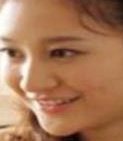

In [154]:
# test image
file_name = 'test11.jpg'
Image(file_name)

In [155]:
get_face_mask_detection(file_name)

'Result: label - nomask, probability - 0.9999920129776001'

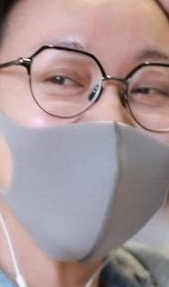

In [156]:
# test image
file_name = 'test02.jpg'
Image(file_name)

In [157]:
get_face_mask_detection(file_name)

'Result: label - mask, probability - 0.9999032020568848'

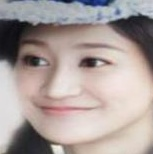

In [158]:
# test image
file_name = 'test12.jpg'
Image(file_name)

In [159]:
get_face_mask_detection(file_name)

'Result: label - nomask, probability - 0.9999629259109497'

### Tuning the model

In [ ]:
from sagemaker.tuner import HyperparameterTuner, IntegerParameter, CategoricalParameter, ContinuousParameter
hyperparameter_ranges = {'optimizer': CategoricalParameter(['sgd', 'adam']),
                         'learning_rate': ContinuousParameter(0.0001, 0.1),
                         'mini_batch_size': IntegerParameter(2, 32),
                        }

objective_metric_name = 'validation:accuracy'

tuner = HyperparameterTuner(face_mask_detection,
                            objective_metric_name,
                            hyperparameter_ranges,
                            max_jobs=50,
                            max_parallel_jobs=3)

tuner.fit(inputs=data_channels, logs=True, include_cls_metadata=False)

In [4]:
import os
import urllib.request

def download(url):
    filename = url.split("/")[-1]
    if not os.path.exists(filename):
        urllib.request.urlretrieve(url, filename)


# Caltech-256 image files
#download('http://www.vision.caltech.edu/Image_Datasets/Caltech256/256_ObjectCategories.tar')
#!tar -xf 256_ObjectCategories.tar

# Tool for creating lst file
download('https://raw.githubusercontent.com/apache/incubator-mxnet/master/tools/im2rec.py')

In [47]:
%%bash
python im2rec.py ./output/mask/images_rec ./images/ --recursive --list --num-thread 8

mask 0
nomask 1
